$$\textrm{Joaquin Peñuela Parra}$$
$$\textrm{Universidad de los Andes}$$
$$\textrm{Grupo de Física de Altas Energías: Fenomenología de Partículas}$$

$\textbf{Preliminares}$ 

Las librerías que se usan en este capítulo son las siguientes: 

In [1]:
import os, sys

Path_Tutorials = os.path.dirname(os.path.realpath('Capitulo_5_Cortes_extra_en_los_datos.ipynb'))
Path_Pheno_BSM = os.path.dirname(Path_Tutorials)
sys.path.append(Path_Pheno_BSM)

from ROOT import TH1F #Para graficar los histogramas usando ROOT
from ROOT import TCanvas #Para poner los histogramas
from ROOT import TFile #Para guardar y leer los histogramas en un archivo .root
from ROOT import THStack #Para graficar varios histogramas al mismo tiempo
from ROOT import TLegend #Para poner legends cuando se sobrelapan histogramas

import numpy as np
import pandas as pd

from delphes_reader import DelphesLoader 
from delphes_reader import root_analysis

from IPython.display import clear_output #Permite limpiar la línea del output para que no se imprima nada (es algo estético que se usa a veces) 
import nbimporter #Permite importar otros notebooks y usar sus funciones
personal_folder = f'{Path_Pheno_BSM}/Tutorials'

Welcome to JupyROOT 6.26/06


En este capítulo se utilizan la lista signals y el directorio XS por esto es necesario volverlos a definir para no tener inconvenientes:

In [2]:
#Definamos una lista con las señales y un directorio para guardar las secciones eficaces:

signals = ["z", "w_jets", "ww", "wz", "zz", "ttbar", "stop"]
XS = {}

#XS de señal:
tabla_ij = pd.read_html(f'{personal_folder}/Data_Z/crossx.html')
columna_xs = tabla_ij[0]['Cross section (pb)']
XS['z'] = float(columna_xs[0].split(' ')[0])    

#XS de backgrounds:
BKGs = ["w_jets", "ww", "wz", "zz", "ttbar", "stop"]

for BKG in BKGs:
    Delphes_Process = DelphesLoader(BKG) #Se crea un objeto de la clase DelphesLoader correspondiente al proceso BKG
    XS[BKG] = float(Delphes_Process.xs) #Extrae la sección eficaz del BKG -  esta en pb
clear_output(wait=False)

In [3]:
#Importemos la función eficiencia del capítulo 3 y la función Overlap_Histos del capítulo 4

from Capitulo_4_Stack_y_No_Stack_de_los_histogramas import Overlap_Histos

$\textbf{Leer los datos de los archivos .csv}$

In [4]:
Datasets_muon0 = {}
Datasets_muon1 = {}
Datasets_correlation = {}
Datasets_Z = {}

for signal in signals:
    Datasets_muon0[signal] = pd.read_csv(f'{personal_folder}/CSV_Z_Analisis/Data_muon0/{signal}.csv')
    del Datasets_muon0[signal][Datasets_muon0[signal].columns[0]] #Borra una columna de ceros que aparecia sin esto
    Datasets_muon1[signal] = pd.read_csv(f'{personal_folder}/CSV_Z_Analisis/Data_muon1/{signal}.csv')
    del Datasets_muon1[signal][Datasets_muon1[signal].columns[0]]
    Datasets_correlation[signal] = pd.read_csv(f'{personal_folder}/CSV_Z_Analisis/Data_correlation/{signal}.csv')
    del Datasets_correlation[signal][Datasets_correlation[signal].columns[0]]
    Datasets_Z[signal] = pd.read_csv(f'{personal_folder}/CSV_Z_Analisis/Data_Z/{signal}.csv')
    del Datasets_Z[signal][Datasets_Z[signal].columns[0]]

cut_flows = pd.DataFrame.to_dict(pd.read_csv(f'{personal_folder}/CSV_Z_Analisis/cut_flows.csv',index_col = 0))

Ahora, para aplicar un filtro más usando los csv es necesario aplicar "mascaras" los DataFrames. Para hacer esto consideremos el siguiente Dataset como ejemplo:

In [5]:
Data = Datasets_Z['ww']

In [6]:
Data

,pT_{Z}(GeV),#eta_{Z},#phi_{Z},Energy_{Z}(GeV),Mass_{Z}(GeV)
0,41.450595,2.246616,0.309652,223.867783,104.153360
1,59.747003,2.090162,0.971970,295.158432,164.215993
2,22.288453,2.348517,-0.077184,179.500828,135.486983
3,39.584572,-1.851892,-0.810271,139.905349,53.625679
4,20.076604,-1.986348,2.568742,149.230630,129.278067
...,...,...,...,...,...
53652,53.771302,0.977552,0.462462,124.022685,93.418551
53653,57.763827,0.599270,0.130570,148.477213,131.757568
53654,118.240363,-1.646961,-2.687746,364.780143,178.198732
53655,81.047414,1.946699,0.426724,292.405380,39.871408


Filtremos los datos donde la Masa debe ser menor que 80

In [7]:
condicion = Data['Mass_{Z}(GeV)'] < 80 #Mascara
Data[condicion] #Así se aplican las mascaras

,pT_{Z}(GeV),#eta_{Z},#phi_{Z},Energy_{Z}(GeV),Mass_{Z}(GeV)
3,39.584572,-1.851892,-0.810271,139.905349,53.625679
5,86.551118,1.750165,-1.760459,260.499931,44.942900
9,64.552304,1.865687,1.529456,218.076590,44.384615
13,54.994275,-1.867358,-2.154572,197.441312,76.096135
15,25.195018,-2.258287,0.289442,142.522331,73.954570
...,...,...,...,...,...
53646,53.422817,-1.908180,-0.080060,194.365979,62.570570
53648,34.328960,-0.541600,-2.398408,62.231749,48.098643
53649,59.592769,-0.304672,1.582085,68.946088,29.364747
53650,51.835245,0.046635,1.157252,63.117998,35.932456


Aquí se puede ver que efectivamente se filtra una gran cantidad de datos, inicialmente había cerca de 50K datos y ahora prácticamente 21K. Dicho esto, ahora si se puede pensar en aplicar este razonamiento a todos nuestros DataSets. 

In [8]:
cut_events_total = 0

for signal in signals:
    condicion_1 = Datasets_Z[signal]['Mass_{Z}(GeV)'] > 66
    condicion_2 = Datasets_Z[signal]['Mass_{Z}(GeV)'] < 116
    
    condicion = condicion_1 == condicion_2
    
    Datasets_muon0[signal] = Datasets_muon0[signal][condicion]
    Datasets_muon1[signal] = Datasets_muon1[signal][condicion]
    Datasets_correlation[signal] = Datasets_correlation[signal][condicion]
    Datasets_Z[signal] = Datasets_Z[signal][condicion]
    
    #Dado que se hizó otro corte en los datos, actualicemos cut_flow
    cut_flows[signal]['66 (GeV) < M(Z) < 116 (Gev)'] = np.shape(Datasets_Z[signal])[0] #Así se añade la cantidad de eventos que quedaron (es la misma que la cantidad de filas del DataFrame)
    cut_events_total += np.shape(Datasets_Z[signal])[0] 
    
cut_flows['Total']['66 (GeV) < M(Z) < 116 (Gev)'] = cut_events_total

Veamos que efectivamente los DataFrames quedaron filtrados:

In [9]:
Datasets_Z['ww']

,pT_{Z}(GeV),#eta_{Z},#phi_{Z},Energy_{Z}(GeV),Mass_{Z}(GeV)
0,41.450595,2.246616,0.309652,223.867783,104.153360
7,53.114040,-0.924029,-0.246987,117.257928,88.039991
8,39.245081,-1.191100,0.320988,130.619104,109.937140
10,62.002916,1.695331,2.506306,198.044925,93.470204
13,54.994275,-1.867358,-2.154572,197.441312,76.096135
...,...,...,...,...,...
53636,84.005668,1.583052,1.662048,229.692393,85.539217
53638,40.822852,0.807773,-1.651672,119.387763,106.025804
53644,1.641304,5.299689,2.067683,182.971205,80.401128
53652,53.771302,0.977552,0.462462,124.022685,93.418551


In [10]:
Datasets_correlation['ww']

,pT_{#mu}(GeV),#eta_{#mu},#phi_{#mu},Energy_{#mu}(GeV),Mass_{#mu}(GeV),#Delta{R}_{#mu#mu},#Delta{#eta}_{#mu#mu},#Delta{#phi}_{#mu#mu},#Delta{pT}_{#mu#mu}(GeV),#Delta{#vec{pT}}_{#mu#mu}(GeV),#Delta{#vec{p}}_{#mu#mu}(GeV)
0,60.238182,1.383534,-0.692575,127.694849,0.105658,2.401791,-0.148018,2.397226,-8.682526,104.187796,108.818697
7,39.735706,-1.350160,-0.892448,81.800828,0.105658,2.339350,1.806169,1.486711,-7.670795,48.918999,99.492394
8,38.905972,0.482427,1.351849,43.521996,0.105658,2.842162,-1.938412,-2.078568,-0.383438,66.746865,118.257856
10,82.062370,1.377220,2.650587,172.993527,0.105658,2.882288,-0.909607,-2.734995,-59.520916,103.152014,174.995737
13,55.697933,-1.261817,-1.467091,106.243060,0.105658,1.952525,-0.280350,-1.932294,-18.387569,77.228723,77.568830
...,...,...,...,...,...,...,...,...,...,...,...
53636,53.587566,1.862228,2.167589,176.661987,0.105658,1.702298,-1.285735,-1.115662,-8.294487,52.813145,150.338553
53638,66.006302,-0.140604,-1.544788,66.659917,0.105658,3.321372,1.483024,-2.971894,-40.219479,91.526385,106.937033
53644,34.720272,0.877224,1.686839,48.958352,0.105658,3.344216,1.195532,3.123217,-1.518101,67.919578,117.040868
53652,58.758224,1.050718,-0.014599,94.289065,0.105658,2.488493,-1.494686,1.989601,-31.732342,73.989876,113.553452


Como se querría en todos los DataFrames de la misma señal se toman solo las filas que cumplan la condición de la masa. Veamos que cut_flows también quedó actualizado como se quiere:

In [11]:
pd.DataFrame(cut_flows)

,Total,z,w_jets,ww,wz,zz,ttbar,stop
Todos,89400073,300000,20942823,12500000,9850000,10000000,24307250,11500000
Al menos 2 muones,936808,210853,104,74404,160145,299277,170215,21810
Exactamente 2 muones,916832,210828,97,74363,148789,291091,169923,21741
Carga opuesta,907174,210821,77,74288,142757,289570,168424,21237
p_T[0] > 30 GeV,853390,190460,26,66691,138989,282760,154900,19564
p_T[1] > 20 GeV,753660,183580,10,54154,123123,251079,125848,15866
|Eta| < 2.4,753660,183580,10,54154,123123,251079,125848,15866
DeltaR > 0.3,751645,183580,6,53657,123001,250981,124738,15682
66 (GeV) < M(Z) < 116 (Gev),620460,180556,2,20741,119827,249272,44512,5550


Guardemos el nuevo cut_flows, lo usaremos en el siguiente capítulo para analizar purezas y significancias.

In [12]:
pd.DataFrame(cut_flows).to_csv(f'{personal_folder}/CSV_Z_Analisis/cut_flows_actualizado.csv')

Ahora crearemos los histogramas usando estos DataFrames filtrados:

In [13]:
#Diccionarios para guardar los Histogramas de cada Dataset:
histogramas_muon0 = {}
histogramas_muon1 = {}
histogramas_correlation = {}
histogramas_Z = {}

#Diccionario que indica los bins con los que se crearán cada histograma
histogramas_bins_dict={
    "#Delta{R}":[8,0,7],
    "#Delta{#eta}":[20,-5,5],
    "#Delta{#phi}":[13,-3.25,3.25],
    "#Delta{pt}":[15, 0.0, 1500.0],
    "#Delta{#vec{pT}}":[30, 0.0, 3000.0],
    "#Delta{#vec{p}}":[30, 0.0, 3000.0],
    "MET(GeV)":[20, 0.0, 1000.0],
    "pT_": [100,0, 180],
    "#eta_":[20, -5, 5],
    "#phi_":[64, -3.2, 3.2],
    "Mass_":[25, 66, 116],
    "Energy_":[20, 0.0, 1000.0]
}

for signal in signals:
    histogramas_muon0[signal] = root_analysis.make_histograms(Datasets_muon0[signal], hist_bins_dict = histogramas_bins_dict)
    histogramas_muon1[signal] = root_analysis.make_histograms(Datasets_muon1[signal], hist_bins_dict = histogramas_bins_dict)
    histogramas_correlation[signal] = root_analysis.make_histograms(Datasets_correlation[signal], hist_bins_dict = histogramas_bins_dict)
    histogramas_Z[signal] = root_analysis.make_histograms(Datasets_Z[signal], hist_bins_dict = histogramas_bins_dict)    
    
histogramas = {'muon0': histogramas_muon0, 'muon1': histogramas_muon1, 'correlation': histogramas_correlation, 'Z': histogramas_Z}

Mass_{#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!
#Delta{pT}_{#mu#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!
Mass_{#mu}(GeV)  is empty!


Tratemos de graficar el Eta que graficamos en el capitulo 3:

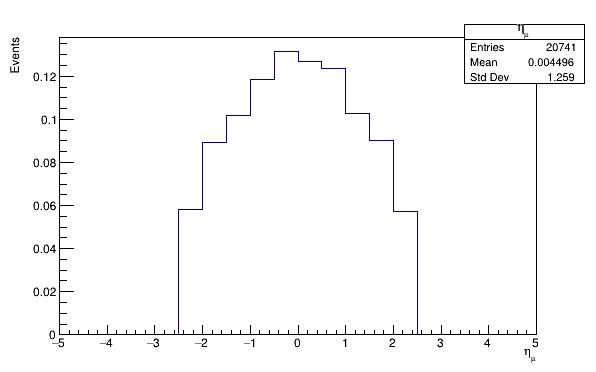

In [14]:
canvas = TCanvas("Canvas", " ", 600, 400)
histogramas['muon1']['ww']['#eta_{#mu}'].Draw('hist')
canvas.Draw()

Efectivamente se grafican menos datos, el filtro está funcionando, ahora utilicemos la función Overlap_histos del capitulo 4 para graficarlos:

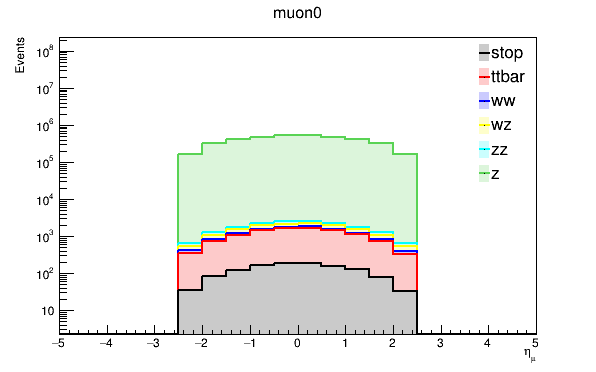

In [15]:
Histos, canvas, legend = Overlap_Histos("muon0", '#eta_{#mu}', histogramas, signals, XS, Path_CSV = personal_folder,
                                        Stack = True, cortes_extra = True, ignorar = 'w_jets', alpha = 0.2, Log = True)

Finalmente, grafiquemos la distribución de la masa reconstruída del Z:

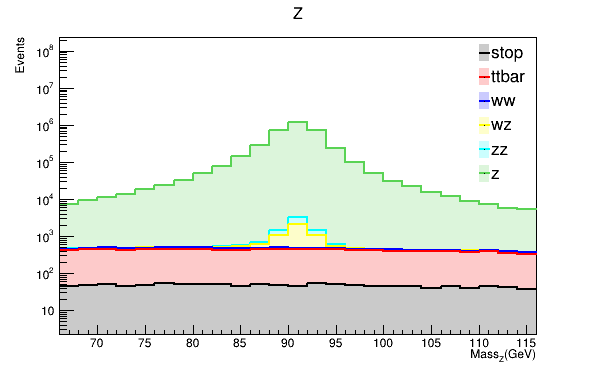

In [16]:
Histos, canvas, legend = Overlap_Histos("Z", 'Mass_{Z}(GeV)', histogramas, signals, XS, Path_CSV = personal_folder,
                                        Stack = True, cortes_extra = True, ignorar = 'w_jets', alpha = 0.2, Log = True)

Esto concuerda con lo presentado en https://cds.cern.ch/record/2707171?ln=es, por lo que se puede decir que la masa fue reconstruída satisfactoriamente.